In [1]:
import re
import sys
import sqlite3
import pickle
import warnings
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import onnx
import tf2onnx
import onnxruntime as ort

from typing import List, Tuple
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import set_random_seed

sys.path.insert(0, '../.')
from config import path_to_base

set_random_seed(0)

In [2]:
conn = sqlite3.connect(path_to_base)
cursor = conn.cursor()

query = f"""
    SELECT
        t.power_true,
        t.temperature,
        t.datetime,
        (CASE WHEN
            day_off_table.day_off = 1
        THEN
            1
        ELSE
            0
        END) AS day_off
    FROM
        consumption_table AS t
        LEFT JOIN day_off_table ON DATE(t.datetime) = DATE(day_off_table.datetime)
    WHERE
        t.power_true IS NOT NULL;
    """
data = pd.read_sql(sql=query, con=conn)
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data.set_index('datetime', inplace=True)
conn.close()

In [3]:
print('data.shape', data.shape)
data.head(2)

data.shape (69780, 3)


,power_true,temperature,day_off
datetime,,,
2016-01-01 00:00:00,3962.983333,-8.313333,1
2016-01-01 01:00:00,3808.266667,-8.260000,1


In [4]:
data.tail(2)

,power_true,temperature,day_off
datetime,,,
2023-12-17 10:00:00,5088.125544,4.165205,1
2023-12-17 11:00:00,5245.737124,4.895359,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69780 entries, 2016-01-01 00:00:00 to 2023-12-17 11:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   power_true   69780 non-null  float64
 1   temperature  69780 non-null  float64
 2   day_off      69780 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.1 MB


In [6]:
def make_data(df               : pd.DataFrame,
              y_lags           : List[int],
              time_freq        : List[str],
              ) -> pd.DataFrame:
    """
    Функция, формирующая датасет для обучения рекуррентной нейронной сети.
    На вход требует:

    Датафрейм df, содержащий данные о почасовом потреблении и темпераутре.

    Датафрейм calendar, содержащий данные о том, выходной день или нет.

    Список лагов для целевой переменной, по которым будет осуществляться сдвиг во времени вперед.
    Рекомендуется давать начиная с единицы. Последнее значение не включается.

    Список частот, по которым необходимо кодировать текущую время и дату.
    Доступны: {'hour', 'day_of_year', 'month', 'weekday'}

    Логическое значение True/False на включение в датасет целевой переменной.
    """
    time_dict = {'hour'        : 24,
                 'day_of_year' : 365.25,
                 'month'       : 12,
                 'weekday'     : 7}

    # так как планируется применять данную функцию и для подготовки данных для предсказания
    # без известного заранее результата, раширим датафрейм вперед, для того, чтобы знать дату и время
    new_index = pd.date_range(start=df.index[-1], periods=y_lags[-1] + 1, freq='H')[y_lags[0] + 1:]
    df = pd.concat([df, pd.DataFrame(index=new_index)])

    # следующеие фичи нужны для рекуррентного входа

    # извлечем тригонометрическую фичу из времени
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for time_component in time_freq:
            df[time_component] = getattr(df.index, time_component)
            df[f'{time_component}_sin'] = np.sin( 2 * np.pi * df[time_component] / time_dict[time_component])
            df[f'{time_component}_cos'] = np.cos( 2 * np.pi * df[time_component] / time_dict[time_component])
            df.drop([time_component], axis=1, inplace=True)

    # следующеие фичи нужны для полносвязного входа
    
    # присоединим к вектору из данных о потреблении и температуре данные о времени,
    # назначенном для конкретного предсказания, а также инфу о рабочем/выходном дне
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for lag in y_lags:
            for time_component in time_freq:
                df[f'{time_component}_sin_{lag}'] = df[f'{time_component}_sin'].shift(-lag - 1)
                df[f'{time_component}_cos_{lag}'] = df[f'{time_component}_cos'].shift(-lag - 1)
            df[f'day_off_{lag}'] = df['day_off'].shift(-lag - 1)
    
    # присоединим к вектору данные о прошлогоднем потреблении и температуре в этот же час,
    # а также сведения о выходном/праздничном дне
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # создадим временный датафрейм, расширенный на год назад, чтобы получить временные сдвиги
        temp_df = pd.concat(
                                [
                                    pd.DataFrame(columns=df.columns,
                                                 index = pd.date_range(start=df.index[0] - relativedelta(years=1),
                                                                       end=df.index[0],
                                                                       freq='H')[:-1]),
                                    df[['power_true', 'temperature', 'day_off']].copy()

                                ],
                                axis=0
                            )

        for lag in tqdm(y_lags):
            # получим соответствующие лагу индексы
            shifted_index = tuple(index - relativedelta(years=1) + relativedelta(hours=lag + 1) for index in df.index)
            # получим значения по временным сдвигам
            df[[f'one_hour_consumption_previos_year_{lag}',
                f'one_hour_temperature_previos_year_{lag}',
                f'day_off_previos_year_{lag}']] = \
                    temp_df.loc[pd.DatetimeIndex(shifted_index), 
                                ['power_true', 'temperature', 'day_off']].values

    # в конце добавим нашу целевую переменную
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for lag in y_lags:
            df[f'y_{lag}'] = df['power_true'].shift(-lag - 1)
    
    # удалим строки, содержащие Nan
    df.dropna(axis=0, inplace=True)

    return df

In [7]:
y_lags=list(range(12, 36))
time_freq = ['hour', 'day_of_year', 'month', 'weekday']

dataset = make_data(
    df       =data,
    y_lags   =y_lags,
    time_freq=time_freq)

print('dataset.shape', dataset.shape)

  0%|          | 0/24 [00:00<?, ?it/s]

dataset.shape (60973, 323)


In [8]:
window_size = 179

df_train = dataset.loc[:'2023-07-30 10:00:00'].copy()
df_test = dataset.loc[pd.to_datetime('2023-07-30 11:00:00') - relativedelta(hours=window_size):].copy()

In [9]:
# рекуррентный вход
# скаллируемые колонки
RNN_input_scalled_cols = ['power_true', 'temperature']

# нескаллируемые колонки
RNN_input_not_scalled_regex = r'[a-zA-Z_]+(?:sin|cos|off)\b'
RNN_input_not_scalled_cols = []

# полносвязный вход
# скаллируемые колонки
Dense_input_scalled_regex = r'(?:one_hour_consumption_previos_year|one_hour_temperature_previos_year)_(\d+)'
Dense_input_scalled_cols = []

# нескаллируемые колонки
Dense_input_not_scalled_regex = r'[a-zA-Z_]+[(?:sin|cos|off)|(?:day_off_previos_year)]_(?=.*\d+)'
Dense_input_not_scalled_cols = []

# целевая колонка
y_regex = r'y_(\d+)'
y_cols = []

for regex, cols in zip([RNN_input_not_scalled_regex, Dense_input_scalled_regex, Dense_input_not_scalled_regex, y_regex], 
                       [RNN_input_not_scalled_cols, Dense_input_scalled_cols, Dense_input_not_scalled_cols, y_cols]):
    cols.extend([col_name for col_name in dataset.columns if re.findall(regex, col_name)])

# не придумал иначе
Dense_input_not_scalled_cols = [item for item in Dense_input_not_scalled_cols if item not in Dense_input_scalled_cols]

RNN_input_cols = RNN_input_scalled_cols + RNN_input_not_scalled_cols
Dense_input_cols = Dense_input_scalled_cols + Dense_input_not_scalled_cols

In [10]:
scaller_RNN = StandardScaler()
scaller_Dense = StandardScaler()

df_train.loc[:, RNN_input_scalled_cols] = scaller_RNN \
    .fit_transform(df_train.loc[:, RNN_input_scalled_cols].values.reshape(-1, len(RNN_input_scalled_cols)))

df_test.loc[:, RNN_input_scalled_cols] = scaller_RNN \
    .transform(df_test.loc[:, RNN_input_scalled_cols].values.reshape(-1, len(RNN_input_scalled_cols)))

df_train.loc[:, Dense_input_scalled_cols] = scaller_Dense \
    .fit_transform(df_train.loc[:, Dense_input_scalled_cols].values.reshape(-1, len(Dense_input_scalled_cols)))

df_test.loc[:, Dense_input_scalled_cols] = scaller_Dense \
    .transform(df_test.loc[:, Dense_input_scalled_cols].values.reshape(-1, len(Dense_input_scalled_cols)))

In [11]:
input_shape_RNN = (window_size + 1, len(RNN_input_cols))
input_shape_Dense = len(Dense_input_cols)
output_shape = len(y_cols)

input_shape_RNN, input_shape_Dense, output_shape

((180, 11), 288, 24)

In [12]:
def generate_sequences(df               : pd.DataFrame,
                       window_size      : int,
                       RNN_input_cols   : List[str],
                       Dense_input_cols : List[str],
                       y_cols           : List[str],) -> Tuple[List[np.array], np.array]:
    """
    Возвращает обучающие примеры для нейронной сети с двумя входами.

    Принимает на вход датафрейм с данными.

    Размер окна, который представляет собой размер предыстории начиная от
    момента времени, в который осуществляеся предсказание (для рекуррентного входа)

    Перечень колонок-предикторов и целевых колонок.
    """
    df.reset_index(drop=True, inplace=True)
    start_index = window_size

    sequence_input_1 = []
    sequence_input_2 = []
    target = []

    input_shape_1 = (-1, window_size + 1, len(RNN_input_cols))
    input_shape_2 = (-1, len(Dense_input_cols))
    output_shape = (-1, len(y_cols))

    while start_index < len(df):
        sequence_input_1.append(df.iloc[start_index - window_size:start_index + 1][RNN_input_cols])
        sequence_input_2.append(df.iloc[start_index][Dense_input_cols])
        target.append(df.iloc[start_index][y_cols])

        start_index += 1
    
    sequence_input_1 = np.array(sequence_input_1).reshape(input_shape_1)
    sequence_input_2 = np.array(sequence_input_2).reshape(input_shape_2)
    target = np.array(target).reshape(output_shape)

    return ([sequence_input_1, sequence_input_2], target)

In [13]:
X_train, y_train = generate_sequences(df=df_train,
                                      window_size=window_size,
                                      RNN_input_cols=RNN_input_cols,
                                      Dense_input_cols=Dense_input_cols,
                                      y_cols=y_cols)

X_test, y_test = generate_sequences(df=df_test,
                                    window_size=window_size,
                                    RNN_input_cols=RNN_input_cols,
                                    Dense_input_cols=Dense_input_cols,
                                    y_cols=y_cols)

In [14]:
X_train[0].shape, X_train[1].shape, y_train.shape

((57469, 180, 11), (57469, 288), (57469, 24))

In [15]:
from keras.models import Model
from keras.layers import Input, SimpleRNN, Conv1D, MaxPooling1D, Dense, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [16]:
# входы
RNN_input = Input(shape=input_shape_RNN)
Dense_input = Input(shape=input_shape_Dense)

# рекуррентная часть
RNN_part = Conv1D(filters=64, kernel_size=3, activation="relu")(RNN_input)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=64, activation='relu', return_sequences=True)(RNN_part)

RNN_part = Conv1D(filters=32, kernel_size=3, activation="relu")(RNN_part)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=32, activation='relu')(RNN_part)

# полносвязная часть
Dense_part = Dense(units=256, activation="relu")(Dense_input)
Dense_part = Dense(units=128, activation="relu")(Dense_part)
Dense_part = Dense(units=64, activation="relu")(Dense_part)

# объединение
merged = concatenate([RNN_part, Dense_part])
common_part = Dense(units=32, activation="relu")(merged)
output = Dense(units=output_shape)(common_part)

# сборка модели
model = Model(inputs=[RNN_input, Dense_input], outputs=output)

# компиляция
model.compile(optimizer='adam', loss='mse', metrics=["mae"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 11)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 178, 64)      2176        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 89, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 simple_rnn (SimpleRNN)         (None, 89, 64)       8256        ['max_pooling1d[0][0]']          
                                                                                              

In [17]:
callbacks = [EarlyStopping(patience=10, restore_best_weights=True),
             ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),]

In [18]:
model.fit(x=X_train,
          y=y_train,
          batch_size=16,
          epochs=100,
          validation_data=(X_test, y_test),
          callbacks=callbacks)

Epoch 1/100
3592/3592 [==============================] - 43s 11ms/step - loss: 552191.3125 - mae: 400.3994 - val_loss: 101595.6953 - val_mae: 253.0103
Epoch 2/100
3592/3592 [==============================] - 41s 11ms/step - loss: 43142.6055 - mae: 162.1106 - val_loss: 40819.7812 - val_mae: 158.0898
Epoch 3/100
3592/3592 [==============================] - 40s 11ms/step - loss: 23853.5332 - mae: 120.7186 - val_loss: 20076.3770 - val_mae: 112.1620
Epoch 4/100
3592/3592 [==============================] - 40s 11ms/step - loss: 19290.8398 - mae: 108.5681 - val_loss: 14439.9697 - val_mae: 95.1101
Epoch 5/100
3592/3592 [==============================] - 40s 11ms/step - loss: 16110.0371 - mae: 98.9462 - val_loss: 12626.5889 - val_mae: 88.3469
Epoch 6/100
3592/3592 [==============================] - 40s 11ms/step - loss: 14208.8545 - mae: 92.4143 - val_loss: 13252.1416 - val_mae: 91.1117
Epoch 7/100
3592/3592 [==============================] - 40s 11ms/step - loss: 12812.5430 - mae: 87.6086 - va

In [19]:
def test_model(model,
               X_train :List[np.ndarray],
               X_test  :List[np.ndarray],
               y_train :np.ndarray,
               y_test  :np.ndarray,
               index   :pd.date_range) -> Tuple[pd.DataFrame]:
    """
    Функция для тестирования модели
    Необходимо передать саму модель
    данные, на которых она обучалась и тестировалась
    диапазон дат для индексирования выходного датафрейма

    Возвращает датафреймы, по которым можно рисовать графики
    """
    # для сопосталения данных выберем среди всех тестовых примеров те,
    # которые соответствуют полным суткам

    X_train_input_1 = X_train[0][::24]
    X_train_input_2 = X_train[1][::24]

    X_test_input_1 = X_test[0][::24]
    X_test_input_2 = X_test[1][::24]

    X_train_for_metrics = [X_train_input_1, X_train_input_2]
    X_test_for_metrics = [X_test_input_1, X_test_input_2]
    
    y_true_train_for_metrics = y_train[::24]
    y_true_test_for_metrics = y_test[::24]

    y_pred_train_for_metrics = model.predict(X_train_for_metrics)
    y_pred_test_for_metrics = model.predict(X_test_for_metrics)

    print('MSE_train:', mean_squared_error(y_true_train_for_metrics, y_pred_train_for_metrics).round(3))
    print('MAE_train:', mean_absolute_error(y_true_train_for_metrics, y_pred_train_for_metrics).round(3))

    print('MSE_test :', mean_squared_error(y_true_test_for_metrics, y_pred_test_for_metrics).round(3))
    print('MAE_test :', mean_absolute_error(y_true_test_for_metrics, y_pred_test_for_metrics).round(3))

    # сформируем датафреймы
    df_true = pd.DataFrame(index = index, data = y_true_test_for_metrics)
    df_pred = pd.DataFrame(index = index, data = y_pred_test_for_metrics)

    return df_true, df_pred

In [20]:
def plot_predicts(df_true   : pd.DataFrame,
                  df_pred   : pd.DataFrame,
                  days_shift: int = 1) -> None:
    """
    Функция для отображения графиков
    принимает на вход датафреймы с инедксами с дневной резолюцией и 24 колнками,
    а также число дней, на которые нужно сдвинуть индексы для отображения
    """
    date_start = (df_true.index[0] + datetime.timedelta(days=days_shift)).date()
    date_end = (df_true.index[-1] + datetime.timedelta(days=days_shift)).date()

    print(f'Реальные и предсказанные значения за период {date_start} - {date_end}'.center(180, "-"))

    _, axes = plt.subplots(nrows=len(df_true)//7,
                           ncols=7,
                           figsize=(14, 2*len(df_true)//7 + 3))

    for i in range(len(df_true)//7):

        for j in range(7):

            ax = axes[i, j]

            ax.plot(range(24), df_true.iloc[i*7 + j], color='blue')
            ax.plot(range(24), df_pred.iloc[i*7 + j], alpha=0.5, color='red')
            
            ax.set_xticks(range(0, 24, 4))
            ax.set_yticks([])

            date = (df_true.index[i*7 + j] + datetime.timedelta(days=days_shift)).date()
            mae = mean_absolute_error(df_true.iloc[i*7 + j], df_pred.iloc[i*7 + j]).round(3)
            new_line = '\n'
            ax.set_title(f'{date}{new_line}MAE: {mae}')

    plt.tight_layout()
    plt.show()

    return None

In [24]:
index = pd.date_range(start='2023-07-31', end='2023-12-16', freq='D')

df_true, df_pred = test_model(model,
                              X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test,
                              index=index)

5/5 [==============================] - 0s 3ms/step
MSE_train: 6214.411
MAE_train: 60.612
MSE_test : 8747.961
MAE_test : 73.122


--------------------------------------------------------Реальные и предсказанные значения за период 2023-07-31 - 2023-12-16---------------------------------------------------------


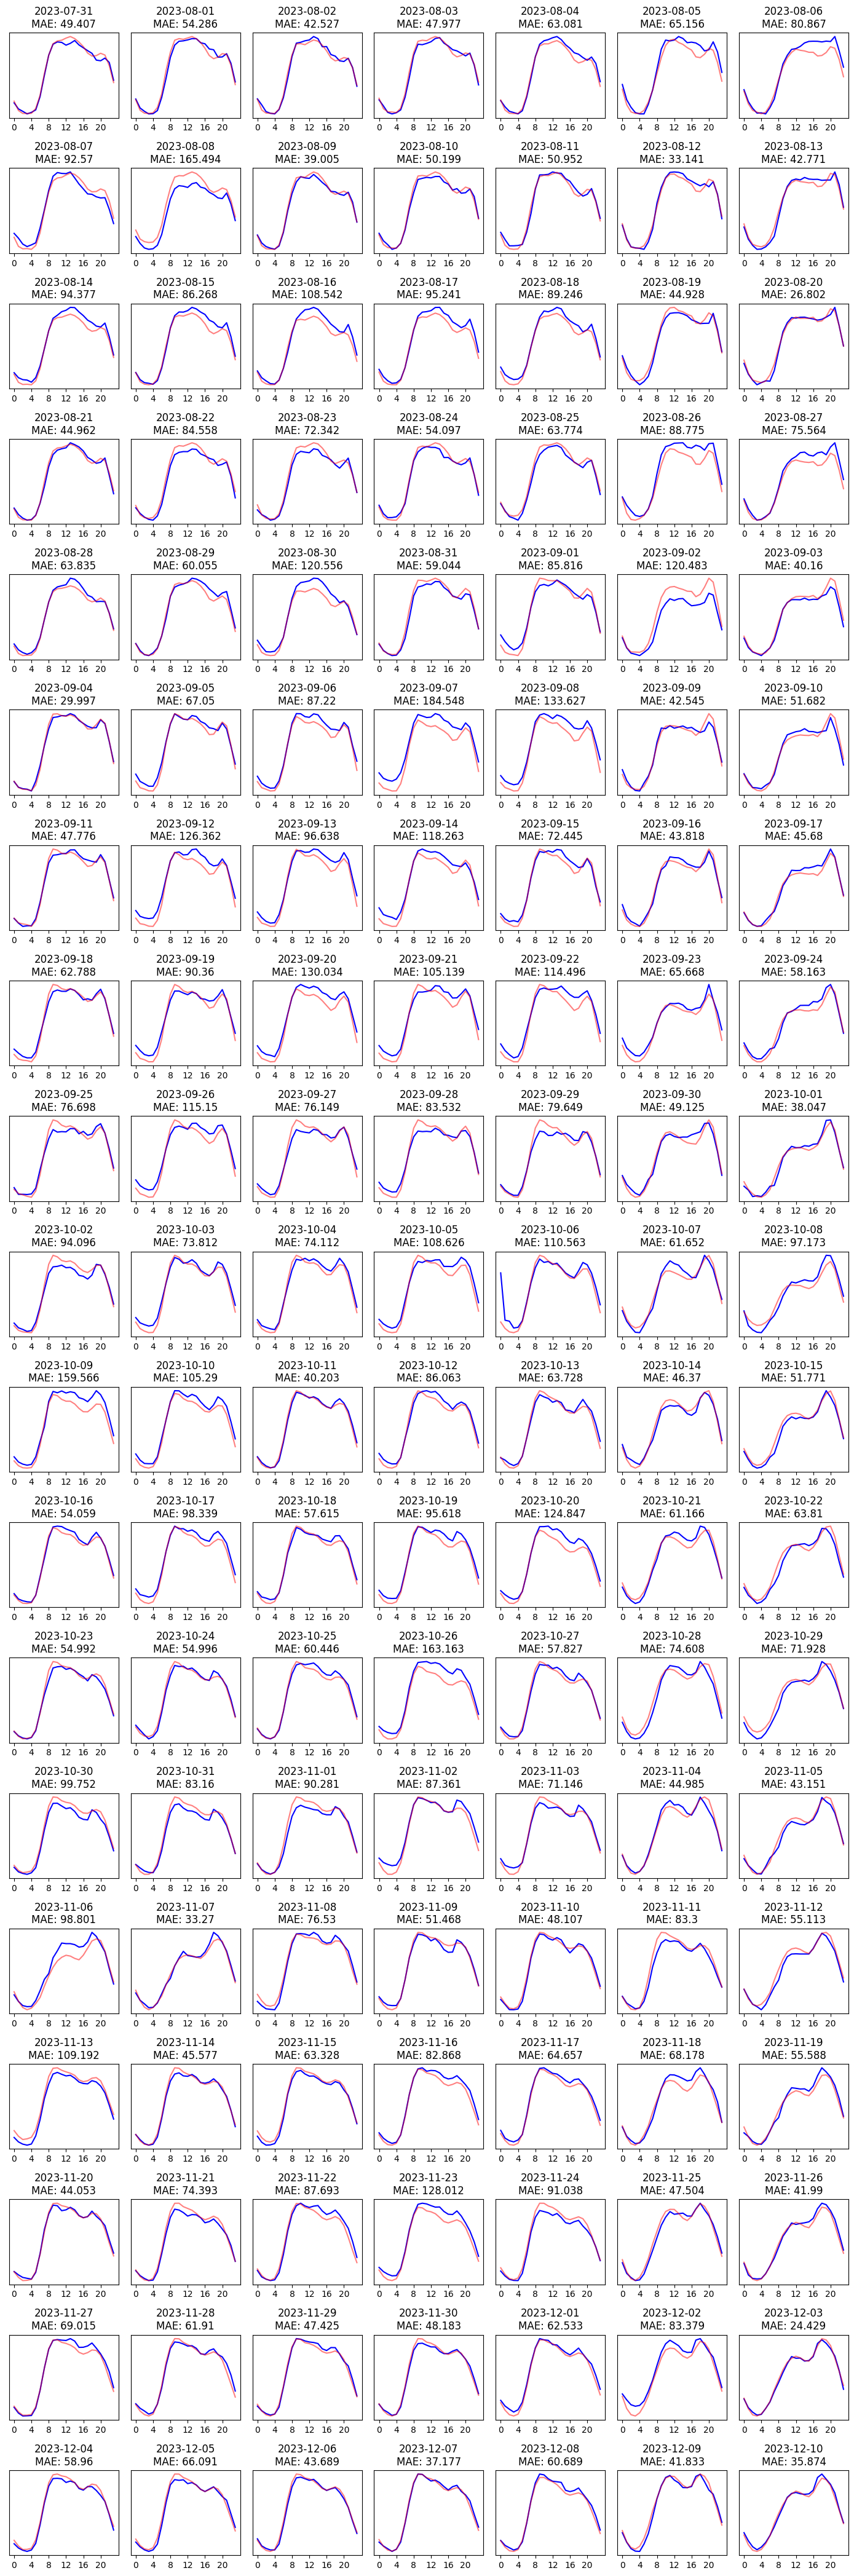

In [25]:
plot_predicts(df_true=df_true,
              df_pred=df_pred,
              days_shift=0)

In [26]:
onnx_model, _ = tf2onnx.convert.from_keras(model)

In [27]:
scaller_RNN, scaller_Dense, onnx_model

(StandardScaler(),
 StandardScaler(),
 ir_version: 8
 producer_name: "tf2onnx"
 producer_version: "1.14.0 8f8d49"
 graph {
   node {
     input: "input_2"
     input: "model/dense/MatMul/ReadVariableOp:0"
     output: "model/dense/MatMul:0"
     name: "model/dense/MatMul"
     op_type: "MatMul"
   }
   node {
     input: "model/dense/MatMul:0"
     input: "model/dense/BiasAdd/ReadVariableOp:0"
     output: "model/dense/BiasAdd:0"
     name: "model/dense/BiasAdd"
     op_type: "Add"
   }
   node {
     input: "model/dense/BiasAdd:0"
     output: "model/dense/Relu:0"
     name: "model/dense/Relu"
     op_type: "Relu"
   }
   node {
     input: "model/dense/Relu:0"
     input: "model/dense_1/MatMul/ReadVariableOp:0"
     output: "model/dense_1/MatMul:0"
     name: "model/dense_1/MatMul"
     op_type: "MatMul"
   }
   node {
     input: "model/dense_1/MatMul:0"
     input: "model/dense_1/BiasAdd/ReadVariableOp:0"
     output: "model/dense_1/BiasAdd:0"
     name: "model/dense_1/BiasAdd"
   

In [28]:
onnx.save(onnx_model, '../new_models/rnn_model.onnx')
with open(f'../new_models/scallers.pickle', 'wb') as file:
    pickle.dump((scaller_RNN, scaller_Dense), file)